In [1]:
using Distributions, Extremes, Random
using DataFrames, CSV
using Gadfly

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/jalbert/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


In [2]:
function slicematrix(A::AbstractMatrix{T}) where T
    n, m = size(A)
    B = Vector{T}[Vector{T}(undef, n) for _ in 1:m]
    for i in 1:m
        B[i] .= A[:, i]
    end
    return B
end


function logf(y::Array{<:Real},x::Array{<:Real},β₀::Real,β₁::Real,ϕ::Real,ξ::Real)
    
    μ = β₀ .+ β₁*x
    σ = exp(ϕ)
    
    pd = GeneralizedExtremeValue.(μ,σ,ξ)
    
    lf = sum(logpdf.(pd,y))
    
    return lf
    
end

function gev_bhm(Y::AbstractArray, X::AbstractArray; β̂₀::Array{<:Real,1}=ones(1), β̂₁::Array{<:Real,1}=ones(1),
        ϕ̂::Array{<:Real,1}=ones(1), ξ̂::Array{<:Real,1}=ones(1), ν̂::Array{<:Real,1}=zeros(4),
        τ̂::Array{<:Real,1}=zeros(4), δ::Array{<:Real}=ones(4), warmup::Int=0, niter::Int=5000 )

    m = length(Y)
    sm = sqrt(m)

    β₀ = zeros(m,niter)
    β₁ = zeros(m,niter)
    ϕ = zeros(m,niter)
    ξ = zeros(m,niter)

    ν = zeros(4,niter)
    τ = ones(4,niter)
    
    β₀[:,1] = β̂₀
    β₁[:,1] = β̂₁
    ϕ[:,1] = ϕ̂
    ξ[:,1] = ξ̂
   
    ν[:,1] = ν̂
    τ[:,1] = τ̂
    
    z = randn(m)
    u = rand(m)
    
    for i=2:niter

        randn!(z)
        β̃₀ = β₀[:,i-1] + z*δ[1]

        lr = logf.(Y,X,β̃₀,β₁[:,i-1],ϕ[:,i-1],ξ[:,i-1]) - 
             logf.(Y,X,β₀[:,i-1],β₁[:,i-1],ϕ[:,i-1],ξ[:,i-1]) +
             logpdf.(Normal(ν[1,i-1],τ[1,i-1]), β̃₀) -
             logpdf.(Normal(ν[1,i-1],τ[1,i-1]), β₀[:,i-1])

        β₀[:,i] = β₀[:,i-1]
        rand!(u)
        ind = lr .> log.(u)
        β₀[ind,i] = β̃₀[ind]



        β̄₀ = mean(β₀[:,i])
        ν[1,i] = rand(Normal(β̄₀,τ[1,i-1]/sm))

        s² = sum( (β₀[:,i] .- ν[1,i]).^2 )

        τ[1,i] = sqrt(rand(InverseGamma(1+m/2,.1+s²/2)))

        randn!(z)
        β̃₁ = β₁[:,i-1] + z*δ[2]

        lr = logf.(Y,X,β₀[:,i],β̃₁,ϕ[:,i-1],ξ[:,i-1]) - 
             logf.(Y,X,β₀[:,i],β₁[:,i-1],ϕ[:,i-1],ξ[:,i-1]) +
             logpdf.(Normal(ν[2,i-1],τ[2,i-1]), β̃₁) -
             logpdf.(Normal(ν[2,i-1],τ[2,i-1]), β₁[:,i-1])

        β₁[:,i] = β₁[:,i-1]
        rand!(u)
        ind = lr .> log.(u)
        β₁[ind,i] = β̃₁[ind]


        β̄₁ = mean(β₁[:,i])
        ν[2,i] = rand(Normal(β̄₁,τ[2,i-1]/sm))

        s² = sum( (β₁[:,i] .- ν[2,i]).^2 )

        τ[2,i] = sqrt(rand(InverseGamma(1+m/2,.1+s²/2)))




        randn!(z)
        ϕ̃ = ϕ[:,i-1] + z*δ[3]

        lr = logf.(Y,X,β₀[:,i],β₁[:,i],ϕ̃,ξ[:,i-1]) - 
             logf.(Y,X,β₀[:,i],β₁[:,i],ϕ[:,i-1],ξ[:,i-1]) +
            logpdf.(Normal(ν[3,i-1],τ[3,i-1]), ϕ̃) -
            logpdf.(Normal(ν[3,i-1],τ[3,i-1]), ϕ[:,i-1])

            ϕ[:,i] = ϕ[:,i-1]
            rand!(u)
            ind = lr .> log.(u)
            ϕ[ind,i] = ϕ̃[ind]



            ϕ̄ = mean(ϕ[:,i])
            ν[3,i] = rand(Normal(ϕ̄,τ[3,i-1]/sm))

            s² = sum( (ϕ[:,i] .- ν[3,i]).^2 )
            τ[3,i] = sqrt(rand(InverseGamma(1+m/2,.1+s²/2)))




        randn!(z)
        ξ̃ = ξ[:,i-1] + z*δ[4]

        lr = logf.(Y,X,β₀[:,i],β₁[:,i],ϕ[:,i],ξ̃) - 
             logf.(Y,X,β₀[:,i],β₁[:,i],ϕ[:,i],ξ[:,i-1]) +
            logpdf.(Normal(ν[4,i-1],τ[4,i-1]), ξ̃) -
            logpdf.(Normal(ν[4,i-1],τ[4,i-1]), ξ[:,i-1])

        ξ[:,i] = ξ[:,i-1]
        rand!(u)
        ind = lr .> log.(u)
        ξ[ind,i] = ξ̃[ind]

        ξ̄ = mean(ξ[:,i])
        ν[4,i] = rand(Normal(ξ̄,τ[4,i-1]/sm))

        s² = sum( (ξ[:,i] .- ν[4,i]).^2 )

        τ[4,i] = sqrt(rand(InverseGamma(1+m/2,.1+s²/2)))

    end
    
    if warmup>0
        β₀ = β₀[:,warmup+1:end]
        β₁ = β₁[:,warmup+1:end]
        ϕ = ϕ[:,warmup+1:end]
        ξ = ξ[:,warmup+1:end]
        ν = ν[:,warmup+1:end]
        τ = τ[:,warmup+1:end]
    end
    
    return β₀, β₁, ϕ, ξ, ν, τ
    
end

function accrate(θ::Array{<:Real})
   
    d = θ[:,2:end] - θ[:,1:end-1]
    rate = 1 .- mean(d .≈ 0)
    
    return rate
    
end

accrate (generic function with 1 method)

# Simulation

In [3]:
# génération des données, x est la variable explicative

m = 50  # nb de membres

n = 300 # nb d'observations

ξ̌ = rand(Normal(.1,.05),1,m)
ϕ̌ = rand(Normal(0,.1),1,m)


x = rand(Normal(0,1),n)
β̌₀ = rand(Normal(1,.1),1,m)
β̌₁ = rand(Normal(1,.05),1,m)
μ̌ = β̌₀ .+ β̌₁.*x

pd = GeneralizedExtremeValue.(μ̌,exp.(ϕ̌),ξ̌) # on suppose la localisation et l'échelle connues
y = rand.(pd)

Y = slicematrix(y);

In [4]:
# valeurs initiales et initialisation

X = Vector{Float64}[Vector{Float64}(undef, n) for _ in 1:m]
for i in 1:m
    X[i] .= x
end

β̂₀ = zeros(m)
β̂₁ = zeros(m)
ϕ̂ = zeros(m)
ξ̂ = zeros(m)

for j=1:m

    fd = gevfit(Y[j],x)

    μ = location.(fd)

    β̂₁[j] = (μ[2] - μ[1]) / (x[2] - x[1]) 
    β̂₀[j] = μ[1] -β̂₁[j]*x[1]
    
    ϕ̂[j] = log(scale(fd[1]))
    
    ξ̂[j] = shape(fd[1])
    
end

ν̂ = vec(mean([β̂₀ β̂₁ ϕ̂ ξ̂], dims=1))
τ̂ = vec([std(β̂₀) .01 std(ϕ̂) .01])

δ = vec([.1 .05 .1 .05])



4-element Array{Float64,1}:
 0.1 
 0.05
 0.1 
 0.05

In [5]:
β₀, β₁, ϕ, ξ, ν, τ = gev_bhm(Y, X, β̂₀ = β̂₀, β̂₁ = β̂₁, ϕ̂ = ϕ̂, ξ̂ = ξ̂, ν̂ = ν̂, τ̂ = τ̂, δ = δ, warmup = 0, niter=10000 );

# calcul du taux d'acceptation
accrate.([β₀, β₁, ϕ, ξ])

4-element Array{Float64,1}:
 0.49120912091209123
 0.6798359835983598 
 0.4265306530653066 
 0.6263826382638265 

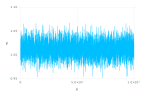

In [6]:
niter = size(ν,2)
plot(x=1:niter, y=ν[2,:], Geom.line)

# Données de ClimEX

In [7]:
data = CSV.read("ClimEx_Mtl_MaxPcp.csv")
y = convert(Matrix{Float64},data)

n, m = size(y)

Y = slicematrix(y);


In [8]:
data = CSV.read("Covariate.csv")
x = convert(Vector{Float64},data[:,1])

x̄ = mean(x)
s = std(x)

x = (x .- x̄)./s

X = Vector{Float64}[Vector{Float64}(undef, n) for _ in 1:m]
for i in 1:m
    X[i] .= x
end

In [9]:
# valeurs initiales et initialisation

β̂₀ = zeros(m)
β̂₁ = zeros(m)
ϕ̂ = zeros(m)
ξ̂ = zeros(m)

for j=1:m

    fd = gevfit(Y[j],x)

    μ = location.(fd)

    β̂₁[j] = (μ[2] - μ[1]) / (x[2] - x[1]) 
    β̂₀[j] = μ[1] -β̂₁[j]*x[1]
    
    ϕ̂[j] = log(scale(fd[1]))
    
    ξ̂[j] = shape(fd[1])
    
end

ν̂ = vec(mean([β̂₀ β̂₁ ϕ̂ ξ̂], dims=1))
τ̂ = vec([std(β̂₀) .01 std(ϕ̂) .01])

δ = vec([.75 .9 .09 .1])

4-element Array{Float64,1}:
 0.75
 0.9 
 0.09
 0.1 

In [10]:
β₀, β₁, ϕ, ξ, ν, τ = gev_bhm(Y, X, β̂₀ = β̂₀, β̂₁ = β̂₁, ϕ̂ = ϕ̂, ξ̂ = ξ̂, ν̂ = ν̂, τ̂ = τ̂, δ = δ, warmup = 0, niter=20000 )

# calcul du taux d'acceptation
accrate.([β₀, β₁, ϕ, ξ])

4-element Array{Float64,1}:
 0.44703535176758835
 0.5657592879643982 
 0.5415650782539128 
 0.49341767088354416

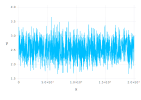

In [11]:
niter = size(ν,2)
plot(x=1:niter, y=ν[2,:], Geom.line)

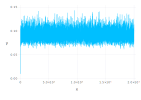

In [12]:
plot(x=1:niter, y=τ[4,:], Geom.line)

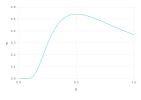

In [13]:
xx = 0:.001:1
plot(x=xx,y=pdf.(InverseGamma(1,1),xx), Geom.line)